### Assignment 1

Submission should be in a Jupyter note book (.ipynb)

1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement for negative numbers. The function signature is 

   ```python
   def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
   # w: width of the binary representation
   # b: binary point
   ```
   Test the following inputs
   ```python
   fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
   ```
   ```python
   fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
   ```
   ```python
   fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])
   ```
   


In [1]:
def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
    a = 0.0
    if bits[0]>0:
        a -= bits[0]*(2**(w-b-1))
    for i in range(1,w):
        a += bits[i]*(2**(w-b-i-1))
    return a

In [2]:
fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])

44.75

In [3]:
fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])

-13.28125

In [4]:
fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])

-21.25

2. Calculate the price of the following questions step by step using two step Cox Rox Rubinstein (CRR) Binomial tree

    a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)?
    

In [5]:
from enum import Enum
import math

In [6]:
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

def crrBinomial(S, r, vol, payoffType, K, T, n):
    t = T / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {PayoffType.Call: lambda s: max(s-K, 0),
                  PayoffType.Put: lambda s: max(K-s, 0),
                 }
    vs = [payoffDict[payoffType](S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

In [7]:
# 2a 
S = 100
r = 0.03
vol = 0.2
K = 105
T = 1
n = 2
payoffType = PayoffType.Call
a = crrBinomial(S, r, vol, payoffType, K, T, n)
print(a)

7.334893644625005


In [8]:
# 2b
S = 100
r = 0.03
vol = 0.2
K = 105
T = 1
n = 2
payoffType = PayoffType.Put
b = crrBinomial(S, r, vol, payoffType, K, T, n)
print(b)

9.231674667218368


In [9]:
# 2c 
S = 100
r = 0.03
vol = 0.1
K = 105
T = 1
n = 2
payoffType = PayoffType.Call
c = crrBinomial(S, r, vol, payoffType, K, T, n)
print(c)

3.555283800757024


In [10]:
# 2d 
S = 100
r = 0.03
vol = 0.1
K = 105
T = 1
n = 2
payoffType = PayoffType.Put
d = crrBinomial(S, r, vol, payoffType, K, T, n)
print(d)

5.452064823350394


In [11]:
# long (a) and short (b)
a - b

-1.8967810225933626

In [12]:
# long (c) and short (d)
c - d

-1.8967810225933701

3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
    * Rho (PV01): the rate of change in the price of an option in response to a change in the interest rate.
    
  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

    \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
    & \text{PV01} = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
    \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2, t = 0, T = 1$, plot each greeks as a function of strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

In [13]:
# binomial pricer for exercise 3
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [14]:
import matplotlib.pyplot as plt

In [15]:
def binomialGreeks(S, r, vol, T, k, greekType) -> float:
    greeks = None
    
    change_S = 0.001
    change_vol = 0.001
    change_t = 0.004
    change_r = 0.0001
    trade = optiontype(T, strike, payoffType)

    S_Zero = binomialPricer(S, r, vol, trade, n, calib)
    
    if greekType == "Delta":
        S_U = binomialPricer(S+change_S*S, r, vol, trade, n, calib)
        S_D = binomialPricer(S-change_S*S, r, vol, trade, n, calib)
        greeks = (S_U-S_D)/(2*change_S*S)
        
    elif greekType == "Gamma":
        S_U = binomialPricer(S+change_S*S, r, vol, trade, n, calib)
        S_D = binomialPricer(S-change_S*S, r, vol, trade, n, calib)
        greeks = (S_U-(2*S_Zero)+S_D)/(change_S*S**2)
        
    elif greekType == "Vega":
        S_U = binomialPricer(S, r, vol+change_vol, trade, n, calib)
        S_D = binomialPricer(S, r, vol-change_vol, trade, n, calib)
        greeks = (S_U-S_D)/(2*change_S)
        
    elif greekType == "Theta":
        trade_t = optiontype(T-change_t, strike, payoffType)
        S_U = binomialPricer(S, r, vol, trade_t, n, calib)
        S_D = binomialPricer(S, r, vol, trade, n, calib)
        greeks = (S_U-S_D)/(change_t)
        
    elif greekType == "Rho":
        S_U = binomialPricer(S, r+change_r, vol, trade, n, calib)
        S_D = binomialPricer(S, r-change_r, vol, trade, n, calib)
        greeks = (S_U-S_D)/(2*change_r)
    else:
        raise Exception("Greek Type Not Supported", greekType)
            
    return greeks

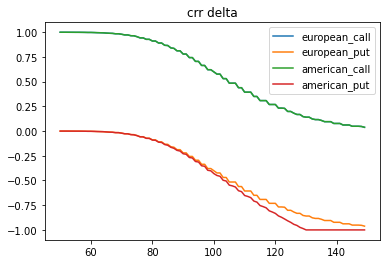

In [16]:
#crr delta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = crrCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
crr_european_call_delta = []
for strike in ks:
    crr_european_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
crr_european_put_delta = []
for strike in ks:
    crr_european_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
crr_american_call_delta = []
for strike in ks:
    crr_american_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
crr_american_put_delta = []
for strike in ks:
    crr_american_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
        
plt.plot(ks, crr_european_call_delta, label="european_call")
plt.plot(ks, crr_european_put_delta, label="european_put")
plt.plot(ks, crr_american_call_delta, label="american_call")
plt.plot(ks, crr_american_put_delta, label="american_put")
plt.title("crr delta")
plt.legend()

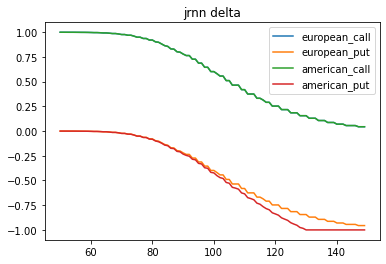

In [17]:
#jrnn delta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jrrnCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jrnn_european_call_delta = []
for strike in ks:
    jrnn_european_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jrnn_european_put_delta = []
for strike in ks:
    jrnn_european_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jrnn_american_call_delta = []
for strike in ks:
    jrnn_american_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jrnn_american_put_delta = []
for strike in ks:
    jrnn_american_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
        
plt.plot(ks, jrnn_european_call_delta, label="european_call")
plt.plot(ks, jrnn_european_put_delta, label="european_put")
plt.plot(ks, jrnn_american_call_delta, label="american_call")
plt.plot(ks, jrnn_american_put_delta, label="american_put")
plt.title("jrnn delta")
plt.legend()

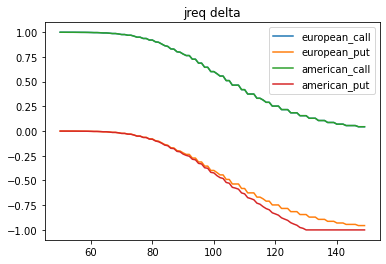

In [18]:
#jreq delta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jreqCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jreq_european_call_delta = []
for strike in ks:
    jreq_european_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jreq_european_put_delta = []
for strike in ks:
    jreq_european_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jreq_american_call_delta = []
for strike in ks:
    jreq_american_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jreq_american_put_delta = []
for strike in ks:
    jreq_american_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
        
plt.plot(ks, jreq_european_call_delta, label="european_call")
plt.plot(ks, jreq_european_put_delta, label="european_put")
plt.plot(ks, jreq_american_call_delta, label="american_call")
plt.plot(ks, jreq_american_put_delta, label="american_put")
plt.title("jreq delta")
plt.legend()

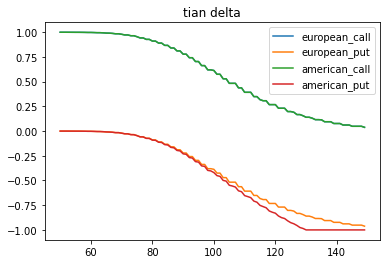

In [19]:
#tian delta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = tianCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
tian_european_call_delta = []
for strike in ks:
    tian_european_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
tian_european_put_delta = []
for strike in ks:
    tian_european_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
tian_american_call_delta = []
for strike in ks:
    tian_american_call_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
tian_american_put_delta = []
for strike in ks:
    tian_american_put_delta.append(binomialGreeks(S, r, vol, T, float(strike), "Delta"))
       
plt.plot(ks, tian_european_call_delta, label="european_call")
plt.plot(ks, tian_european_put_delta, label="european_put")
plt.plot(ks, tian_american_call_delta, label="american_call")
plt.plot(ks, tian_american_put_delta, label="american_put")
plt.title("tian delta")
plt.legend()

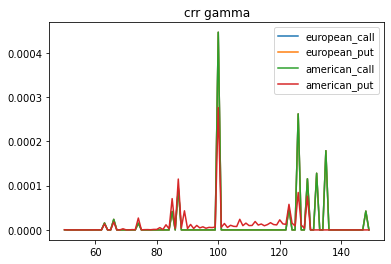

In [20]:
#crr gamma
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = crrCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
crr_european_call_gamma = []
for strike in ks:
    crr_european_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
crr_european_put_gamma = []
for strike in ks:
    crr_european_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
crr_american_call_gamma = []
for strike in ks:
    crr_american_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
crr_american_put_gamma = []
for strike in ks:
    crr_american_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
        
plt.plot(ks, crr_european_call_gamma, label="european_call")
plt.plot(ks, crr_european_put_gamma, label="european_put")
plt.plot(ks, crr_american_call_gamma, label="american_call")
plt.plot(ks, crr_american_put_gamma, label="american_put")
plt.title("crr gamma")
plt.legend()

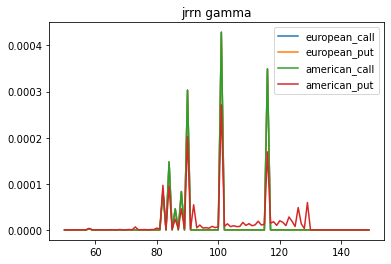

In [21]:
#jrrn gamma
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jrrnCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jrrn_european_call_gamma = []
for strike in ks:
    jrrn_european_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jrrn_european_put_gamma = []
for strike in ks:
    jrrn_european_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jrrn_american_call_gamma = []
for strike in ks:
    jrrn_american_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jrrn_american_put_gamma = []
for strike in ks:
    jrrn_american_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
        
plt.plot(ks, jrrn_european_call_gamma, label="european_call")
plt.plot(ks, jrrn_european_put_gamma, label="european_put")
plt.plot(ks, jrrn_american_call_gamma, label="american_call")
plt.plot(ks, jrrn_american_put_gamma, label="american_put")
plt.title("jrrn gamma")
plt.legend()

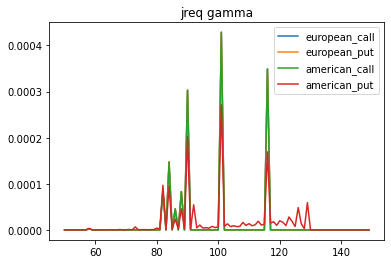

In [22]:
#jreq gamma
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jreqCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jreq_european_call_gamma = []
for strike in ks:
    jreq_european_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jreq_european_put_gamma = []
for strike in ks:
    jreq_european_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jreq_american_call_gamma = []
for strike in ks:
    jreq_american_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jreq_american_put_gamma = []
for strike in ks:
    jreq_american_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
        
plt.plot(ks, jreq_european_call_gamma, label="european_call")
plt.plot(ks, jreq_european_put_gamma, label="european_put")
plt.plot(ks, jreq_american_call_gamma, label="american_call")
plt.plot(ks, jreq_american_put_gamma, label="american_put")
plt.title("jreq gamma")
plt.legend()

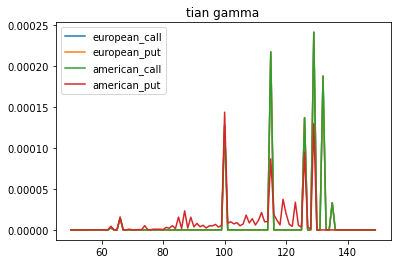

In [23]:
#tian gamma
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = tianCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
tian_european_call_gamma = []
for strike in ks:
    tian_european_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
tian_european_put_gamma = []
for strike in ks:
    tian_european_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
tian_american_call_gamma = []
for strike in ks:
    tian_american_call_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
tian_american_put_gamma = []
for strike in ks:
    tian_american_put_gamma.append(binomialGreeks(S, r, vol, T, float(strike), "Gamma"))
        
plt.plot(ks, tian_european_call_gamma, label="european_call")
plt.plot(ks, tian_european_put_gamma, label="european_put")
plt.plot(ks, tian_american_call_gamma, label="american_call")
plt.plot(ks, tian_american_put_gamma, label="american_put")
plt.title("tian gamma")
plt.legend()

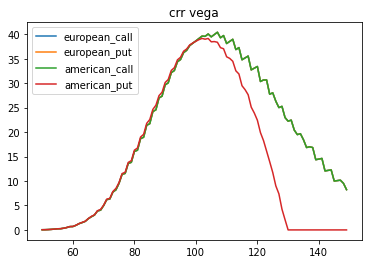

In [24]:
#crr vega
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = crrCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
crr_european_call_vega = []
for strike in ks:
    crr_european_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
crr_european_put_vega = []
for strike in ks:
    crr_european_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
crr_american_call_vega = []
for strike in ks:
    crr_american_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
crr_american_put_vega = []
for strike in ks:
    crr_american_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
        
plt.plot(ks, crr_european_call_vega, label="european_call")
plt.plot(ks, crr_european_put_vega, label="european_put")
plt.plot(ks, crr_american_call_vega, label="american_call")
plt.plot(ks, crr_american_put_vega, label="american_put")
plt.title("crr vega")
plt.legend()

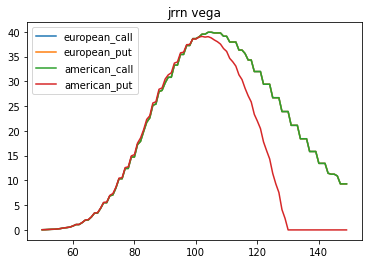

In [25]:
#jrrn vega
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jrrnCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jrrn_european_call_vega = []
for strike in ks:
    jrrn_european_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jrrn_european_put_vega = []
for strike in ks:
    jrrn_european_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jrrn_american_call_vega = []
for strike in ks:
    jrrn_american_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jrrn_american_put_vega = []
for strike in ks:
    jrrn_american_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
        
plt.plot(ks, jrrn_european_call_vega, label="european_call")
plt.plot(ks, jrrn_european_put_vega, label="european_put")
plt.plot(ks, jrrn_american_call_vega, label="american_call")
plt.plot(ks, jrrn_american_put_vega, label="american_put")
plt.title("jrrn vega")
plt.legend()

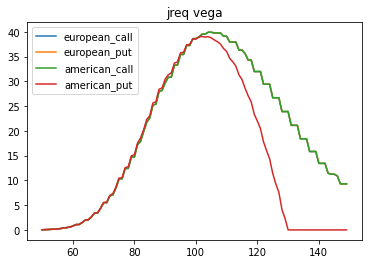

In [26]:
#jreq vega
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jreqCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jreq_european_call_vega = []
for strike in ks:
    jreq_european_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jreq_european_put_vega = []
for strike in ks:
    jreq_european_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jreq_american_call_vega = []
for strike in ks:
    jreq_american_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jreq_american_put_vega = []
for strike in ks:
    jreq_american_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
        
plt.plot(ks, jreq_european_call_vega, label="european_call")
plt.plot(ks, jreq_european_put_vega, label="european_put")
plt.plot(ks, jreq_american_call_vega, label="american_call")
plt.plot(ks, jreq_american_put_vega, label="american_put")
plt.title("jreq vega")
plt.legend()

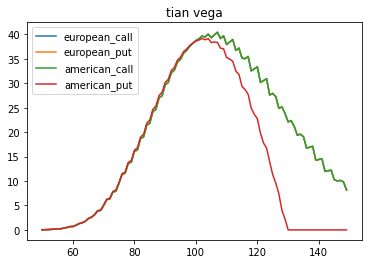

In [27]:
#tian vega
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = tianCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
tian_european_call_vega = []
for strike in ks:
    tian_european_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
tian_european_put_vega = []
for strike in ks:
    tian_european_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
tian_american_call_vega = []
for strike in ks:
    tian_american_call_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
tian_american_put_vega = []
for strike in ks:
    tian_american_put_vega.append(binomialGreeks(S, r, vol, T, float(strike), "Vega"))
        
plt.plot(ks, tian_european_call_vega, label="european_call")
plt.plot(ks, tian_european_put_vega, label="european_put")
plt.plot(ks, tian_american_call_vega, label="american_call")
plt.plot(ks, tian_american_put_vega, label="american_put")
plt.title("tian vega")
plt.legend()

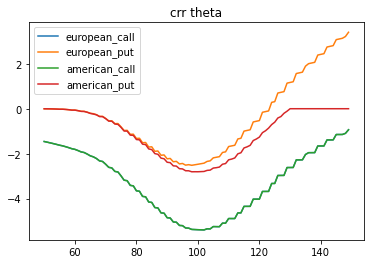

In [28]:
#crr theta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = crrCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
crr_european_call_theta = []
for strike in ks:
    crr_european_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
crr_european_put_theta = []
for strike in ks:
    crr_european_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
crr_american_call_theta = []
for strike in ks:
    crr_american_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
crr_american_put_theta = []
for strike in ks:
    crr_american_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
        
plt.plot(ks, crr_european_call_theta, label="european_call")
plt.plot(ks, crr_european_put_theta, label="european_put")
plt.plot(ks, crr_american_call_theta, label="american_call")
plt.plot(ks, crr_american_put_theta, label="american_put")
plt.title("crr theta")
plt.legend()

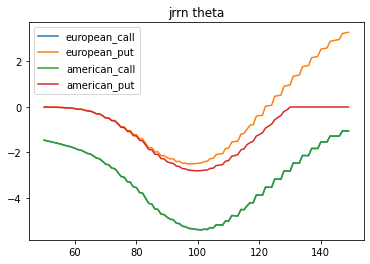

In [29]:
#jrrn theta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jrrnCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jrrn_european_call_theta = []
for strike in ks:
    jrrn_european_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jrrn_european_put_theta = []
for strike in ks:
    jrrn_european_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jrrn_american_call_theta = []
for strike in ks:
    jrrn_american_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jrrn_american_put_theta = []
for strike in ks:
    jrrn_american_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
        
plt.plot(ks, jrrn_european_call_theta, label="european_call")
plt.plot(ks, jrrn_european_put_theta, label="european_put")
plt.plot(ks, jrrn_american_call_theta, label="american_call")
plt.plot(ks, jrrn_american_put_theta, label="american_put")
plt.title("jrrn theta")
plt.legend()

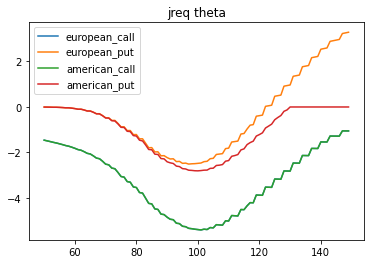

In [30]:
#jreq theta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jreqCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jreq_european_call_theta = []
for strike in ks:
    jreq_european_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jreq_european_put_theta = []
for strike in ks:
    jreq_european_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jreq_american_call_theta = []
for strike in ks:
    jreq_american_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jreq_american_put_theta = []
for strike in ks:
    jreq_american_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
        
plt.plot(ks, jreq_european_call_theta, label="european_call")
plt.plot(ks, jreq_european_put_theta, label="european_put")
plt.plot(ks, jreq_american_call_theta, label="american_call")
plt.plot(ks, jreq_american_put_theta, label="american_put")
plt.title("jreq theta")
plt.legend()

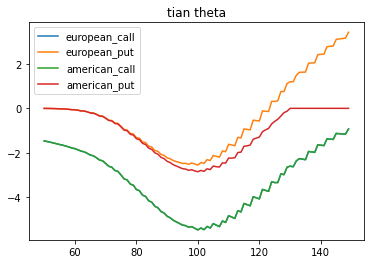

In [31]:
#tian theta
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = tianCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
tian_european_call_theta = []
for strike in ks:
    tian_european_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
tian_european_put_theta = []
for strike in ks:
    tian_european_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
tian_american_call_theta = []
for strike in ks:
    tian_american_call_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
tian_american_put_theta = []
for strike in ks:
    tian_american_put_theta.append(binomialGreeks(S, r, vol, T, float(strike), "Theta"))
        
plt.plot(ks, tian_european_call_theta, label="european_call")
plt.plot(ks, tian_european_put_theta, label="european_put")
plt.plot(ks, tian_american_call_theta, label="american_call")
plt.plot(ks, tian_american_put_theta, label="american_put")
plt.title("tian theta")
plt.legend()

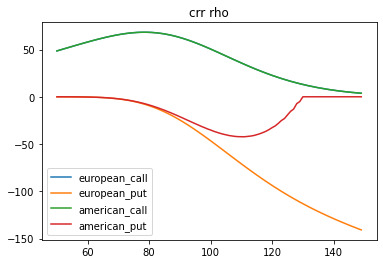

In [32]:
#crr rho
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = crrCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
crr_european_call_rho = []
for strike in ks:
    crr_european_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
crr_european_put_rho = []
for strike in ks:
    crr_european_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
crr_american_call_rho = []
for strike in ks:
    crr_american_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
crr_american_put_rho = []
for strike in ks:
    crr_american_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
        
plt.plot(ks, crr_european_call_rho, label="european_call")
plt.plot(ks, crr_european_put_rho, label="european_put")
plt.plot(ks, crr_american_call_rho, label="american_call")
plt.plot(ks, crr_american_put_rho, label="american_put")
plt.title("crr rho")
plt.legend()

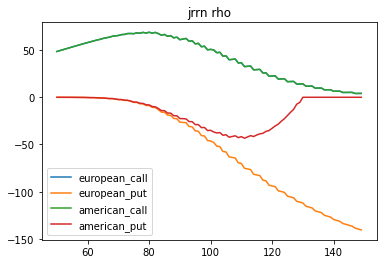

In [33]:
#jrrn rho
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jrrnCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jrrn_european_call_rho = []
for strike in ks:
    jrrn_european_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jrrn_european_put_rho = []
for strike in ks:
    jrrn_european_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jrrn_american_call_rho = []
for strike in ks:
    jrrn_american_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jrrn_american_put_rho = []
for strike in ks:
    jrrn_american_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
        
plt.plot(ks, jrrn_european_call_rho, label="european_call")
plt.plot(ks, jrrn_european_put_rho, label="european_put")
plt.plot(ks, jrrn_american_call_rho, label="american_call")
plt.plot(ks, jrrn_american_put_rho, label="american_put")
plt.title("jrrn rho")
plt.legend()

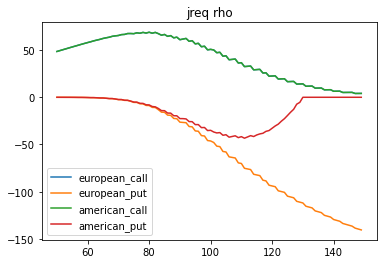

In [34]:
#jreq rho
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = jreqCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
jreq_european_call_rho = []
for strike in ks:
    jreq_european_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
jreq_european_put_rho = []
for strike in ks:
    jreq_european_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
jreq_american_call_rho = []
for strike in ks:
    jreq_american_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
jreq_american_put_rho = []
for strike in ks:
    jreq_american_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
        
plt.plot(ks, jreq_european_call_rho, label="european_call")
plt.plot(ks, jreq_european_put_rho, label="european_put")
plt.plot(ks, jreq_american_call_rho, label="american_call")
plt.plot(ks, jreq_american_put_rho, label="american_put")
plt.title("jreq rho")
plt.legend()

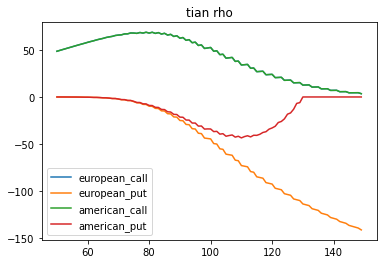

In [35]:
#tian rho
S = 100
r = 0.03
vol = 0.2
ks = range(50,150)
T = 1
n = 300
calib = tianCalib

payoffType = PayoffType.Call
optiontype = EuropeanOption
tian_european_call_rho = []
for strike in ks:
    tian_european_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = EuropeanOption
tian_european_put_rho = []
for strike in ks:
    tian_european_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Call
optiontype = AmericanOption
tian_american_call_rho = []
for strike in ks:
    tian_american_call_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
    
payoffType = PayoffType.Put
optiontype = AmericanOption
tian_american_put_rho = []
for strike in ks:
    tian_american_put_rho.append(binomialGreeks(S, r, vol, T, float(strike), "Rho"))
        
plt.plot(ks, tian_european_call_rho, label="european_call")
plt.plot(ks, tian_european_put_rho, label="european_put")
plt.plot(ks, tian_american_call_rho, label="american_call")
plt.plot(ks, tian_american_put_rho, label="american_put")
plt.title("tian rho")
plt.legend()